In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import random
from tqdm.notebook import tqdm
from scipy import signal
from scipy.integrate import trapz

In [2]:
# Read Data and Data Preprocessing

df = pd.read_excel("ML AP Data 2023 Full Series(Jan2).xlsx")
df.replace(r'^\s*$', np.nan, regex=True)
df = df.T.reset_index()
df.columns = df.iloc[0, :]
df = df.iloc[1:, :304005]
df.shape

(142, 304005)

In [3]:
#Create intermediary dataframes separating data and metadata to facilitate
#further processing
df_data = df.iloc[:, 5:].T.reset_index()
df_data = df_data.rename(columns={0:"Time"})
df_data.Time = pd.to_datetime(df_data.Time, unit="s")
df_data.index = df_data.Time
df_data = df_data.iloc[:, 1:]
df_meta = df.iloc[:, :5].rename(columns={"Condition":"Surgery"})
df_data.head()

,1,2,3,4,5,6,7,8,9,10,...,133,134,135,136,137,138,139,140,141,142
Time,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.000,130.1223,130.4467,131.7845,172.6916,154.5692,155.522,131.0142,126.5749,148.0217,155.6233,...,136.5482,120.8382,156.1301,160.6708,122.845,167.2386,150.5961,145.731,160.4884,161.1979
1970-01-01 00:00:00.001,129.9399,130.1021,131.4399,173.6038,154.9138,155.2382,130.5075,126.2911,147.7784,156.0085,...,137.2375,120.453,155.8666,159.9005,122.7031,167.9279,150.4339,146.7649,159.8194,161.1168
1970-01-01 00:00:00.002,129.6561,129.6764,131.2778,174.4146,155.4409,154.8733,130.1831,125.9059,147.4946,156.5558,...,138.0888,119.9462,155.6841,159.3532,122.2571,168.6779,150.2515,147.6771,158.9275,160.8938
1970-01-01 00:00:00.003,129.3926,129.1899,130.9737,175.1241,155.7652,154.63,129.7777,125.5613,147.2919,157.0423,...,138.9402,119.6016,155.4814,158.8464,122.0342,169.286,149.988,148.6501,158.3396,160.6505
1970-01-01 00:00:00.004,129.0074,128.9466,130.7102,175.9552,156.1098,154.4476,129.575,125.014,147.1906,157.5896,...,139.7511,119.257,155.3193,158.3802,121.7706,169.8739,149.7853,149.6636,157.468,160.4276


In [4]:
#@title Downsampler
def downsample(freq, df = df_data, meta = df_meta):
    '''
    Downsample BP data to specified samplerate in milliseconds by taking the mean
    '''
    #convert the samplerate provided (in Hz) to time in milliseconds.
    ms = 1 / freq * 1000
    ms = round(ms, 3)
    #Resample the dataframe using the df.resample method
    df = df.resample(f"{ms}ms").mean()
    df = pd.concat([df_meta, df.reset_index(drop=True).T], axis = 1)
    return df

In [5]:
# @title Call Downsampler
freq = 100

df_done = downsample(freq)
print("downsampler is done!")
print(df_done.head())

downsampler is done!
    ID   Sex Diet     Age Surgery          0          1          2          3  \
1   F1  Male   NC  24 wks     NaN   128.9324    131.371  143.77286  154.66248   
2   F9  Male   NC  24 wks     NaN  128.74593  125.09104  122.15783  121.07941   
3  F10  Male   NC  24 wks     NaN  130.65341  128.05468  124.47278  120.65574   
4  F17  Male   NC  24 wks     NaN   176.1782  181.96151  185.03258  184.17715   
5  F18  Male   NC  24 wks     NaN  156.39563  160.60798  163.70943  164.17161   

           4  ...      30390      30391      30392      30393      30394  \
1  159.93294  ...        NaN        NaN        NaN        NaN        NaN   
2  128.68713  ...  125.88568  122.77812  120.26045  123.95789  134.70358   
3   117.0414  ...        NaN        NaN        NaN        NaN        NaN   
4  178.59042  ...        NaN        NaN        NaN        NaN        NaN   
5  161.11677  ...        NaN        NaN        NaN        NaN        NaN   

       30395      30396     30397  

In [6]:
# Create folders for PSD data & figures
if not os.path.exists("PSD_data"):
                os.makedirs("PSD_data")
        
if not os.path.exists("PSD_figures"):
                os.makedirs("PSD_figures")

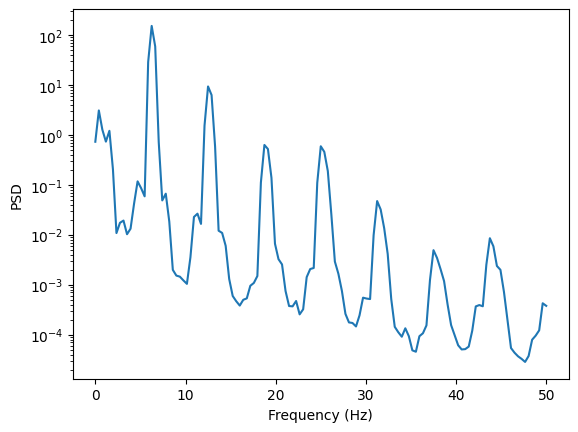

In [ ]:
# @title Binary Classifications Salient Frequencies

y=df_done.set_index(['ID', 'Sex', 'Diet', 'Age', 'Surgery'])

for labels, data in y.iterrows():
    a, b, c, d, e = labels
    name = str(a) + str(b) + str(c) + str(d) + str(e)
    ts = data.dropna()
    f, psd = signal.welch(ts, fs=100, nperseg=256)

    start_freq_47 = 42.578125  # Starting frequency
    end_freq_47 = 47.65625  # Ending frequency

    # Find the indices corresponding to the specified frequency range
    start_index_47 = np.where(all_data['freq'] >= start_freq_47)[0][0]
    end_index_47 = np.where(all_data['freq'] <= end_freq_47)[0][-1]

    # Extract the frequency and PSD values within the specified range
    freq_range_47 = all_data['freq'].iloc[start_index_47:end_index_47 + 1]
    psd_range_47 = all_data[column].iloc[start_index_47:end_index_47 + 1]

    # Calculate the area under the curve using the trapezoidal rule
    area_47 = trapz(psd_range_47, x=freq_range_47)                

    analysis = pd.DataFrame({'freq': f, 'psd': psd, 'area 47': area_47})
    analysis.to_excel(f'PSD_data/{name}.xlsx', index=False)

    # Plot the PSD
    plt.clf()
    plt.semilogy(f, psd)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.savefig(f'PSD_figures/{name}.png')

In [ ]:
# @title Multiclass Salient Frequencies

y=df_done.set_index(['ID', 'Sex', 'Diet', 'Age', 'Surgery'])

for labels, data in y.iterrows():
    a, b, c, d, e = labels
    name = str(a) + str(b) + str(c) + str(d) + str(e)
    ts = data.dropna()
    f, psd = signal.welch(ts, fs=100, nperseg=256)

    start_freq_47 = 42.578125  # Starting frequency
    end_freq_47 = 47.65625  # Ending frequency

    # Find the indices corresponding to the specified frequency range
    start_index_47 = np.where(all_data['freq'] >= start_freq_47)[0][0]
    end_index_47 = np.where(all_data['freq'] <= end_freq_47)[0][-1]

    # Extract the frequency and PSD values within the specified range
    freq_range_47 = all_data['freq'].iloc[start_index_47:end_index_47 + 1]
    psd_range_47 = all_data[column].iloc[start_index_47:end_index_47 + 1]

    # Calculate the area under the curve using the trapezoidal rule
    area_47 = trapz(psd_range_47, x=freq_range_47)
    analysis.to_excel(f'PSD_data/{name}.xlsx', index=False)

    # Plot the PSD
    #plt.clf()
    #plt.semilogy(f, psd)
    #plt.xlabel('Frequency (Hz)')
    #plt.ylabel('PSD')
    #plt.savefig(f'PSD_figures/{name}.png')

In [ ]:
# @title code for AUC of PSD Plot
y=df_done.set_index(['ID', 'Sex', 'Diet', 'Age', 'Surgery'])

for labels, data in y.iterrows():
    a, b, c, d, e = labels
    name = str(a) + str(b) + str(c) + str(d) + str(e)
    ts = data.dropna()
    f, psd = signal.welch(ts, fs=100, nperseg=256)

    start_freq = 42.578125  # Starting frequency
    end_freq = 47.65625  # Ending frequency

    # Find the indices corresponding to the specified frequency range
    start_index = np.where(f >= start_freq)[0][0]
    end_index = np.where(f <= end_freq)[0][-1]

    # Extract the frequency and PSD values within the specified range
    freq_range = f[start_index:end_index + 1]
    psd_range = psd[start_index:end_index + 1]

    # Calculate the area under the curve using the trapezoidal rule
    area = trapz(psd_range, x=freq_range)

    areas = pd.DataFrame()
    break

F1MaleNC24 wksnan 3.074385749825233


In [ ]:
from scipy.integrate import trapz

# assume you have frequency and PSD values in two numpy arrays
freq = 100
psd = psd

# calculate the area under the curve using the trapezoidal rule
area = trapz(psd, x=freq)

print('Area under the curve: {:.2f}'.format(area))